Loading MNIST dataset...
MNIST dataset loaded.


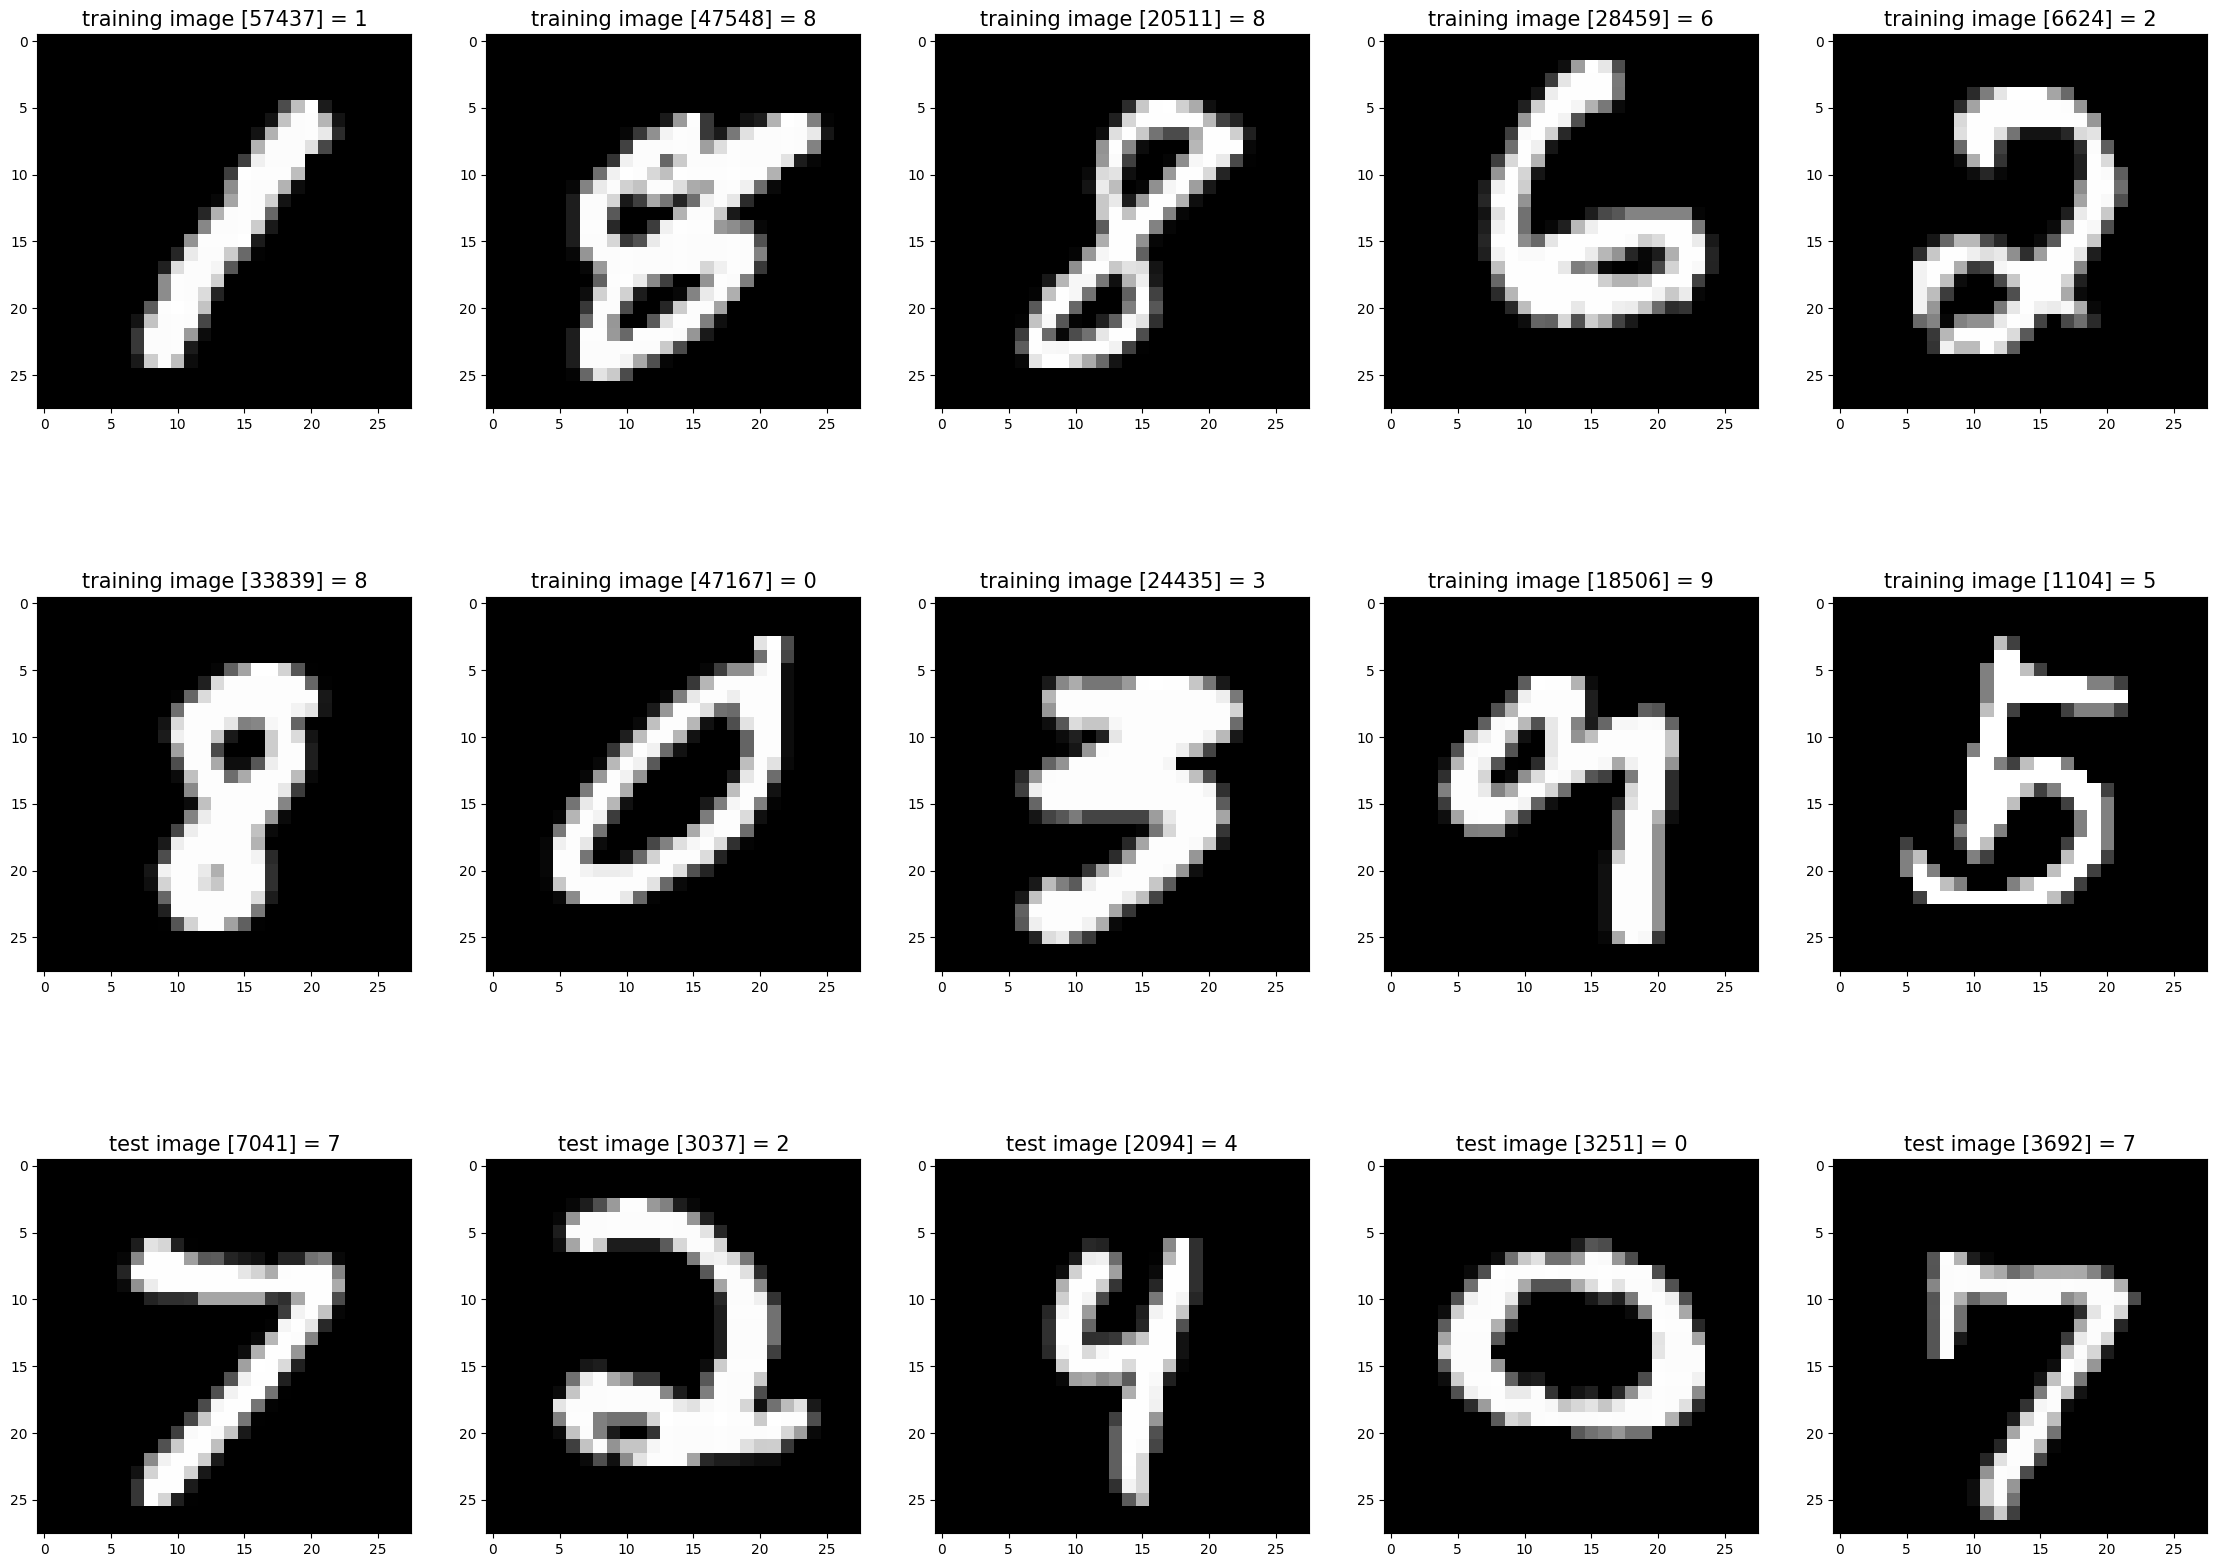

In [14]:
import numpy as np
import math
import matplotlib.pyplot as plt
import os
import time
import random
from os.path  import join
import struct
from array import array
class MnistDataloader(object):
    def __init__(self, training_images_filepath,training_labels_filepath,
                 test_images_filepath, test_labels_filepath):
        self.training_images_filepath = training_images_filepath
        self.training_labels_filepath = training_labels_filepath
        self.test_images_filepath = test_images_filepath
        self.test_labels_filepath = test_labels_filepath

    def read_images_labels(self, images_filepath, labels_filepath):
        labels = []
        with open(labels_filepath, 'rb') as file:
            magic, size = struct.unpack(">II", file.read(8))
            if magic != 2049:
                raise ValueError('Magic number mismatch, expected 2049, got {}'.format(magic))
            labels = array("B", file.read())

        with open(images_filepath, 'rb') as file:
            magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
            if magic != 2051:
                raise ValueError('Magic number mismatch, expected 2051, got {}'.format(magic))
            image_data = array("B", file.read())
        images = []
        for i in range(size):
            images.append([0] * rows * cols)
        for i in range(size):
            img = np.array(image_data[i * rows * cols:(i + 1) * rows * cols])
            img = img.reshape(28, 28)
            images[i][:] = img

        return images, labels

    def load_data(self):
        x_train, y_train = self.read_images_labels(self.training_images_filepath, self.training_labels_filepath)
        x_test, y_test = self.read_images_labels(self.test_images_filepath, self.test_labels_filepath)
        return (x_train, y_train),(x_test, y_test)

# Set file paths based on added MNIST Datasets
training_images_filepath = 'mnist-dataset/train-images.idx3-ubyte'
training_labels_filepath = 'mnist-dataset/train-labels.idx1-ubyte'
test_images_filepath = 'mnist-dataset/t10k-images.idx3-ubyte'
test_labels_filepath = 'mnist-dataset/t10k-labels.idx1-ubyte'


# Load MINST dataset
print('Loading MNIST dataset...')
mnist_dataloader = MnistDataloader(training_images_filepath, training_labels_filepath, test_images_filepath, test_labels_filepath)
(X_train, y_train), (X_test, y_test) = mnist_dataloader.load_data()
print('MNIST dataset loaded.')

# Show example images
def show_images(images, title_texts):
    cols = 5
    rows = int(len(images)/cols) + 1
    plt.figure(figsize=(28, 28))
    index = 1
    for x in zip(images, title_texts):
        image = x[0]
        title_text = x[1]
        plt.subplot(rows, cols, index)
        plt.imshow(image, cmap=plt.cm.gray)
        if (title_text != ''):
            plt.title(title_text, fontsize = 15);
        index += 1

random_images = []
for i in range(0, 10):
    r = random.randint(1, 60000)
    random_images.append((X_train[r], 'training image [' + str(r) + '] = ' + str(y_train[r])))
for i in range(0, 5):
    r = random.randint(1, 10000)
    random_images.append((X_test[r], 'test image [' + str(r) + '] = ' + str(y_test[r])))

show_images(list(map(lambda x: x[0], random_images)), list(map(lambda x: x[1], random_images)))

In [15]:
def to_categorical(y, num_classes=None):
    """
    Преобразует массив меток классов в формат one-hot encoding.

    :param y: Массив меток классов (1D numpy array).
    :param num_classes: Общее количество классов. Если None, будет определено автоматически.
    :return: Массив в формате one-hot encoding (2D numpy array).
    """
    y = np.array(y, dtype='int')

    if num_classes is None:
        num_classes = np.max(y) + 1  # Определяем количество классов автоматически

    # Создаем массив нулей с размерностью (количество меток, количество классов)
    one_hot = np.zeros((len(y), num_classes))

    # Заполняем массив единицами в нужных позициях
    one_hot[np.arange(len(y)), y] = 1

    return one_hot

In [16]:
X_train = np.array(X_train).reshape(-1, 28 * 28) / 255.0  # Преобразование в одномерный массив и нормализация
X_test = np.array(X_test).reshape(-1, 28 * 28) / 255.0    # То же самое для тестовых данных
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

In [18]:
def relu(x):
    return np.maximum(0, x)

In [25]:
def drelu(x):
    return x >= 0

In [20]:
def softmax(x):
    exp_x = np.exp(x - np.max(x))
    return exp_x / exp_x.sum(axis=1, keepdims=True)

In [21]:
# Параметры
input_size = 28 * 28
hidden_size = 300
output_size = 10
learning_rate = 0.1
batch_size = 32
epochs = 20

In [22]:
# Инициализация весов
stddev = np.sqrt(2. / input_size)
W1 = np.random.randn(input_size, hidden_size) * stddev
b1 = np.zeros((1, hidden_size))
stddev = np.sqrt(2. / hidden_size)
W2 = np.random.randn(hidden_size, output_size) * stddev
b2 = np.zeros((1, output_size))

In [26]:
# Обучение
for epoch in range(epochs):
    time_start = time.time()
    for i in range(0, len(X_train), batch_size):
        X_batch = X_train[i:i+batch_size]
        y_batch = y_train[i:i+batch_size]

        # Прямое распространение
        z1 = np.dot(X_batch, W1) + b1
        a1 = relu(z1)
        z2 = np.dot(a1, W2) + b2
        a2 = softmax(z2)

        # Вычисление ошибки
        loss = -np.mean(np.sum(y_batch * np.log(a2), axis=1))

        # Обратное распространение
        delta2 = a2 - y_batch
        delta1 = np.dot(delta2, W2.T) * drelu(z1)

        # Обновление весов и смещений
        W2 -= learning_rate * np.dot(a1.T, delta2) / batch_size
        b2 -= learning_rate * np.mean(delta2, axis=0)
        W1 -= learning_rate * np.dot(X_batch.T, delta1) / batch_size
        b1 -= learning_rate * np.mean(delta1, axis=0)
    time_end = time.time()
    print(f'Epoch {epoch + 1}/{epochs}, Loss: {loss:.4f}, Time: {time_end - time_start}')

Epoch 1/20, Loss: 0.0417, Time: 7.924880027770996
Epoch 2/20, Loss: 0.0263, Time: 5.896809339523315
Epoch 3/20, Loss: 0.0248, Time: 7.91020131111145
Epoch 4/20, Loss: 0.0203, Time: 5.785394191741943
Epoch 5/20, Loss: 0.0190, Time: 7.816863536834717
Epoch 6/20, Loss: 0.0159, Time: 5.822546482086182
Epoch 7/20, Loss: 0.0135, Time: 7.896517515182495
Epoch 8/20, Loss: 0.0119, Time: 5.769128322601318
Epoch 9/20, Loss: 0.0100, Time: 7.932733774185181
Epoch 10/20, Loss: 0.0091, Time: 5.7672154903411865
Epoch 11/20, Loss: 0.0080, Time: 8.23070764541626
Epoch 12/20, Loss: 0.0071, Time: 5.768735408782959
Epoch 13/20, Loss: 0.0061, Time: 7.878135681152344
Epoch 14/20, Loss: 0.0052, Time: 5.738565444946289
Epoch 15/20, Loss: 0.0045, Time: 8.822760105133057
Epoch 16/20, Loss: 0.0035, Time: 5.757727146148682
Epoch 17/20, Loss: 0.0032, Time: 7.977161407470703
Epoch 18/20, Loss: 0.0028, Time: 5.800146818161011
Epoch 19/20, Loss: 0.0025, Time: 7.8371076583862305
Epoch 20/20, Loss: 0.0023, Time: 5.74355

In [27]:
# Оценка точности на тестовых данных
test_predictions = softmax(np.dot(relu(np.dot(X_test, W1) + b1), W2) + b2)
accuracy = np.mean(np.argmax(test_predictions, axis=1) == np.argmax(y_test, axis=1))
print(f'Test accuracy: {accuracy:.4f}')

Test accuracy: 0.9802
